Random Forests for (Fruits and Vegetables) Image Classification

Import numpy and sklearn method.

In [1]:
import numpy as np
from sklearn.datasets import load_files

print(np.__version__)

1.20.1


Copy dataset from git repo.

In [2]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset

fatal: destination path 'Fruit-Images-Dataset' already exists and is not an empty directory.


Set the path directory to the cloned test and train data.
load_dataset() returns the filenames, integer classes and string classes that are stored in file directory.


1.   names_train is a vector that contains the filepath of all images from the training set
2.   names_test is a vector that contains the filepath of all images from the test set
3.   intclass_train is a vector containing the int class values (1-131) of all images from the training set
4.   intclass_test is a vector containing the int class values (1-131) of all images from the test set
5.   stringclass_train is a vector containing the string label of class of all images from the training set
6.   stringclass_test is a vector containing the string label of class of all images from the test set






In [3]:
import os
base_dir = os.getcwd()
base_dir

'C:\\Users\\Adriano\\Desktop\\MCD\\FAA\\Project1\\ImageClassification'

In [4]:
train_dir = base_dir+'/Fruit-Images-Dataset/Training/'
test_dir = base_dir+'/Fruit-Images-Dataset/Test/'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels

names_train, intclass_train, stringclass_train = load_dataset(train_dir)
names_test, intclass_test, stringclass_test = load_dataset(test_dir)

print('Loading complete!')
print('Training set size : ',  names_train.shape[0])
print('Testing set size : ', names_test.shape[0])
print(stringclass_train)
print(intclass_train.shape)
print(stringclass_train.shape)

Loading complete!
Training set size :  67692
Testing set size :  22688
['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Corn' 'Corn Husk'
 'Cucumber Ripe' 'Cucumber Ripe 2' 'Dates' 'Eggplant' 'Fig' 'Ginger Root'
 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White' 'Grape White 2'
 'Grape White 3' 'Grape White 4' 'Grapefruit Pink' 'Grapefruit White'
 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi' 'Kohlrabi' 'Kumquats'
 'Lemon' 'Lemon Meyer' 'Limes' 'Lychee' 'Mandarine' 'Mango' 'Mango Red'
 'Mangostan' 

In [5]:
print(stringclass_train.shape)
print(stringclass_test.shape)


(131,)
(131,)


Show distribution of images to the different classes.

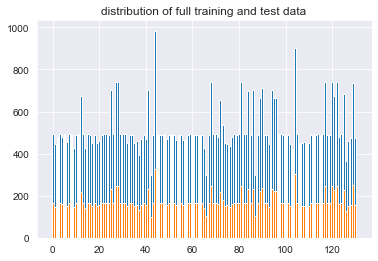

In [6]:
import matplotlib.pyplot as plt

(intclass, counts) = np.unique(intclass_train, return_counts=True)
plt.bar(intclass, counts)
plt.title('distribution of full training and test data')
full_train_frequencies = np.asarray((intclass, counts)).T

(intclass, counts) = np.unique(intclass_test, return_counts=True)
plt.bar(intclass, counts)
full_test_frequencies = np.asarray((intclass, counts)).T

Datasets can be reduced for compiling: original size of the training dataset is 67692 images; original size of the test dataset is 22688 images.

In [7]:
i = 0
while i < 20:
  print('Name : ', names_train[i])
  print('Intclass : ', intclass_train[i])
  i+=1


Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Cherry 2\r_263_100.jpg
Intclass :  27
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Nut Pecan\73_100.jpg
Intclass :  73
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Melon Piel de Sapo\r_45_100.jpg
Intclass :  68
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Redcurrant\120_100.jpg
Intclass :  114
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Strawberry Wedge\r_176_100.jpg
Intclass :  117
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Peach\206_100.jpg
Intclass :  80
Name :  C:\Users\Adriano\Desktop\MCD\FAA\Project1\ImageClassification/Fruit-Images-Dataset/Training/Nut Forest\87_100.jpg
Intclass :  72
Name :  C:\Users\Adrian

In [8]:
print('Training set size : ',  names_train.shape[0])
print('Testing set size : ', names_test.shape[0])

Training set size :  67692
Testing set size :  22688


Amount of different classes in the test set.

In [9]:
n_classes = len(np.unique(intclass_test))
n_classes


131

Change name of image to actual pixel array.
The _images_array are the inputs (100x100 pixels with 3 color channels).


In [10]:
!pip install tensorflow --user
import tensorflow

In [11]:
from tensorflow import keras

In [12]:
#from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

train_images_array = np.array(convert_image_to_array(names_train))
print('Training set shape : ', train_images_array.shape)

test_images_array = np.array(convert_image_to_array(names_test))
print('Test set shape : ', test_images_array.shape)

print('1st training image shape ',train_images_array[0].shape)

Training set shape :  (67692, 100, 100, 3)
Test set shape :  (22688, 100, 100, 3)
1st training image shape  (100, 100, 3)


Pixel arrays of one image (100x100 pixels, 3 color channels).

In [13]:
print('1st training image as array',train_images_array[0])

1st training image as array [[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


Rescale pixel values from 0-255 range to 0-1.


1.   train_images_array is an array containing the normalized pixel values of the train images.
2.   test_images_array is an array containing the normalized pixel values of the test images.
3.   valid_images_array is an array containing the normalized pixel values of the validation images.



In [14]:
train_images_array = train_images_array.astype('float32')/255
test_images_array = test_images_array.astype('float32')/255

In [15]:
from sklearn.model_selection import train_test_split
#split the training dataset ito trainset anbd testset (reduce computation power)

new_train_images_array, new_test_images_array, new_train_intclass, new_test_intclass = train_test_split(train_images_array, intclass_train, test_size=0.3, random_state=42)

In [16]:
#train_datasize = 40000
#test_datasize = 10000
#names_train = names_train[:train_datasize]
#names_test = names_test[:test_datasize]
#intclass_train = intclass_train[:train_datasize]
#intclass_test = intclass_test[:test_datasize]
print('Training set size : ',  names_train.shape[0])
print('Testing set size : ', names_test.shape[0])
#print(stringclass_train)
print('Training set LABELS size : ',intclass_train.shape)
print('Testing set LABELS size : ',intclass_test.shape)

Training set size :  67692
Testing set size :  22688
Training set LABELS size :  (67692,)
Testing set LABELS size :  (22688,)


In [17]:
n_classes_train = len(np.unique(intclass_train))
print('Number of classes in training: ',n_classes_train)
n_classes_test = len(np.unique(intclass_test))
print('Number of classes in testing: ',intclass_test)

Number of classes in training:  131
Number of classes in testing:  [107  64  88 ...  58  64  16]


In [18]:
print('New Training set size : ',  new_train_images_array.shape[0])
print('New Testing set size : ', new_test_images_array.shape[0])
print('New Training set LABELS size : ', new_train_intclass.shape)
print('New Testing set LABELS size : ',new_test_intclass.shape)

New Training set size :  47384
New Testing set size :  20308
New Training set LABELS size :  (47384,)
New Testing set LABELS size :  (20308,)


In [19]:
n_classes_train = len(np.unique(new_train_intclass))
print('Number of classes in new training: ',n_classes_train)
n_classes_test = len(np.unique(new_test_intclass))
print('Number of classes in new testing: ',n_classes_test)

Number of classes in new training:  131
Number of classes in new testing:  131


Following the code in the link below

https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/


In [20]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = new_train_images_array.shape
train_flat_images_array = new_train_images_array.reshape((nsamples,nx*ny*nrgb))

In [21]:
#so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = new_test_images_array.shape
test_flat_images_array = new_test_images_array.reshape((nsamples,nx*ny*nrgb))

In [22]:
from datetime import datetime

# Getting the current date and time
dt1 = datetime.now()

# getting the timestamp
ts1 = datetime.timestamp(dt1)

print("Date and time is:", dt1)
print("Timestamp is:", ts1)

Date and time is: 2022-11-15 11:13:27.416021
Timestamp is: 1668510807.416021


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

from sklearn.model_selection import GridSearchCV

param_grid={
    'n_estimators':[1,10, 20, 50], #,100,1000],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth':[10,50,100], #,1000],
    'max_features':['sqrt', 'log2', None],
    'min_impurity_decrease':[0.05,0.1,0.5],
    'bootstrap':[False],
    'random_state':[42],
    'ccp_alpha':[0.0,0.05,0.1,0.5],
}
#applying 5-fold cross validation to choose hyperparameter
rf_gs=GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

In [ ]:
rf_gs.fit(train_flat_images_array,new_train_intclass)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [ ]:
# Getting the current date and time
dt2 = datetime.now()

# getting the timestamp
ts2 = datetime.timestamp(dt2)

print("Date and time is:", dt2)
print("Timestamp is:", ts2)

In [ ]:
# difference between dates in timedelta
delta = dt2 - dt1
print(f'Difference is {delta.seconds} seconds')
print(f'Difference is {delta.seconds/60} minutes')

In [ ]:
best_params = rf_gs.best_estimator_.get_params()
best_params

In [ ]:
intclass_test_pred=rf_gs.best_estimator_.predict(test_flat_images_array)
intclass_test_pred

In [ ]:
#train_score = score(train_flat_images_array,intclass_train)
#test_score = score(test_flat_images_array,intclass_test)
#print(f'The model has {train_score*100}% accuracy in the train set')
#print(f'The model has {test_score*100}% accuracy in the test set')


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [ ]:
acc = accuracy_score(intclass_test_pred,new_test_intclass)
acc

In [ ]:
print("The predicted Data is :")
print(np.array(intclass_test_pred))
print("The actual data is:")
print(np.array(new_test_intclass))
print(f"The model is {acc*100}% accurate (in the test set)")

In [ ]:
print(classification_report(intclass_test_pred,new_test_intclass))

# Ploting the scores of gridsearcchcv
https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

# Ploting the Consusion Matrix

In [ ]:
cm = confusion_matrix(intclass_test_pred,new_test_intclass)
cm

In [ ]:
df = pd.DataFrame(cm).replace(0, np.nan)

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=[20,20])
sns.heatmap(df, annot=True, fmt='g', cmap="Blues")
plt.show()

In [ ]:
#selecting the higher values outside of the diagonal (biggest confusion between classing)
#and associating it with the original class and the predicted class

#for example if green apples and red apples have some confusion it is not as much a problem as bananas and red apples

In [ ]:
#sum(sum(cm==21))